# Lab 4: Logisitic Regression


## Import and Inspect Data

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

heartData = pd.read_csv("D:\Programming\Python_code\PrinciplesOfDS_Course\Labs\Data\heart.csv")
print(heartData.info()) # all data types int or float, no non-numeric features. No categorical features to convert 

print(heartData.head())

# Option setup: 
pd.set_option("display.max_rows", 1500)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      1

<AxesSubplot: >

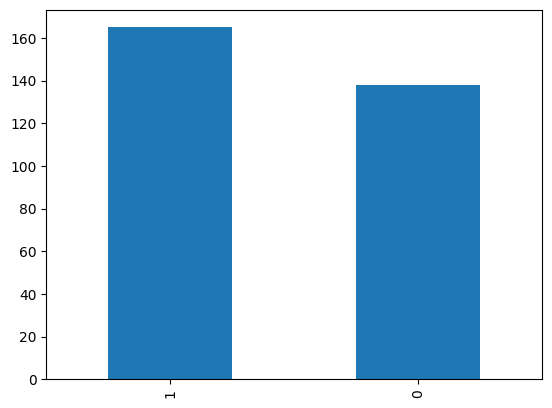

In [2]:
# Check for missing values 
heartData.isna().sum()/heartData.shape[0] # all values 0. No missing values. 

#heartData['target'].hist() # fast and informative, but ugly. 

# still fast. less noise. 
heartData.target.value_counts().plot(kind = 'bar') # Data is balanced with no significant dominance of samples by either of two categories. 
# balanced data means an accuracy measure is appropriate. 

## Split and Normalize Data


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from random import shuffle
import random

X, y = heartData.drop(columns='target'), heartData.target

# Subtle but important step for this cross-validation workflow: Convert y to ndarry
y = y.to_numpy() ##########################

# samples should be divided for same size folds, at 10 folds we need a value divisible by 10 
X.shape[0] # 303 observations

260/303 # 0.858085808580858 ; 85% of data for trainig and ~15% for testing is a good split ratio 

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size= 0.14, random_state=2)

print(X_train_val.shape) # correct split value achieved 
print(y_train_val.shape)

normalizer = StandardScaler()
X_train_val = normalizer.fit_transform(X_train_val)
X_test = normalizer.transform(X_test)

print(X_train_val)
print(type(y_train_val), y_train_val) # the assignment of values is just wrong here.. not sure why, but I am getting indices from all over... ok. nvm makes sense.. its random selection.. but its fucking up my validation
print(type(y_train_val))
print(type(y_test))
print(type(X_train_val))
print(type(X_test))
# ok ... so the type of my data is affecting the processing here.. series has the index attached, an ndarray seems to not carry index with it... thus my issue of referencing values emerges. ... too in the weeds to think about how I would solve this without dropping the series data structure.. also not clear on if it matters in the first place tbh. ... should consider this when I am not as confused. 

(260, 13)
(260,)
[[-0.50885855  0.68478212 -0.95381269 ... -0.67388958 -0.71183597
   1.13120328]
 [-1.28191577 -1.4603185   0.99121711 ... -0.67388958 -0.71183597
  -0.50275701]
 [-0.50885855  0.68478212  0.99121711 ... -0.67388958  0.29951568
   1.13120328]
 ...
 [-2.82803021  0.68478212  0.01870221 ...  0.96359912 -0.71183597
  -0.50275701]
 [-0.50885855 -1.4603185   0.99121711 ... -0.67388958 -0.71183597
  -0.50275701]
 [ 0.92681915  0.68478212 -0.95381269 ... -0.67388958  0.29951568
   1.13120328]]
<class 'numpy.ndarray'> [0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 0
 0 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1
 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 1 0 0 1
 1 0 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0
 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 0 0 0
 1 1 0 0 1 1 0 1 

In [28]:
# 10 fold cross-validation
folds = 10

# total number of training samples
num_train_val = X_train_val.shape[0]

#shuffleing indices of samples to remove potential ordering bias
sample_idx = np.arange(num_train_val)
shuffle(sample_idx)

print(sample_idx.shape)

# splitting indices into 10 folds
folds_idx = sample_idx.reshape(folds, -1)
print('index of folds\n', folds_idx)

# set of hyperparameters to be tested
regTerms = [.00001, .0001, .001, .01, .1, 1, 10, 20, 50, 100]

best_acc = 0.0
best_reg = 0.0
best_f1 = 0.0
best_precision = 0.0
best_recall = 0.0

for reg in regTerms:
    
    # 10-fold cross-validation
    sum_acc = 0.0
    sum_f1 = 0.0
    sum_precision = 0.0
    sum_recall = 0.0
    
    for fold in range(folds):
        
        index_of_folds_temp = folds_idx.copy()
        
        valid_index = index_of_folds_temp[fold,:].reshape(-1) #get the index of the validation set
        train_index = np.delete(index_of_folds_temp, fold, 0).reshape(-1) #get the index of the training set
      
        # training set
        X_train = X_train_val[train_index]
        y_train = y_train_val[train_index]
        
        # validation set
        X_valid = X_train_val[valid_index]
        y_valid = y_train_val[valid_index]
                
        # build the model with different hyperparameters
        clf = LogisticRegression(penalty='l2', C=reg, solver='lbfgs')
        
        #train the model with the training set
        clf.fit(X_train, y_train)
        
        y_valid_pred = clf.predict(X_valid)
        acc = accuracy_score(y_valid, y_valid_pred)
        f1 = f1_score(y_valid, y_valid_pred)
        precision = precision_score(y_valid, y_valid_pred)
        recall = recall_score(y_valid, y_valid_pred)
        
        sum_acc += acc
        sum_f1 += f1
        sum_precision += precision 
        sum_recall += recall
    
    cur_acc = sum_acc / folds
    cur_f1 = sum_f1 / folds
    cur_precision = sum_precision / folds
    cur_recall = sum_recall / folds
    
    print("reg_coeff: {}, acc: {:.3f}".format(1.0/reg, cur_acc))
    
    # store the best hyperparameter
    if cur_acc > best_acc:
        best_acc = cur_acc
        best_reg = reg
        
    # storing best of each metric to see if they're associated with different regularization terms 
    if cur_f1 > best_f1:
        best_f1 = cur_f1
        best_f1_reg = reg
    if cur_precision > best_precision:
        best_precision = cur_precision
        best_precision_reg = reg
    if cur_recall > best_recall:
        best_recall = cur_recall
        best_recall_reg = reg

        
print('best_acc', best_acc, 'best_reg', best_reg)
print("best_f1 and f1 reg:", best_f1, best_f1_reg)
print("best_precision and precision reg:", best_precision, best_precision_reg)
print("best_recall and recall reg:", best_recall, best_recall_reg)

(260,)
index of folds
 [[  5 197 164 129 132  97  37 237 213   4 189  75 152  51 143 148 211 202
  243 183   9 151 128 247  61 177]
 [249  59  56 140 235 159 146  39  72  44 179   7 108 180 206  64  82 157
   29 160  45 182  83  53 184 134]
 [ 99 230 236 199  55  62 204  46 112 198 107  65 161 252  79 192 145 232
  118  52   1  54  15 218 171 169]
 [ 10 102 166  40  21  28  49   8 101 255 238 203  93 135 122 188  78  24
  124  85 113 190 233 103   6 212]
 [ 88 163 158  14 114 175  92 168 121 155 105  47 231 162 116  12  89 117
   33 178 126  84 137 125  73 223]
 [ 58 216 253  18 186 226 131 214 229  67  34 207 200 130 110 181  42  98
   68 209 259  17   3 257  63 251]
 [147 136 144  27 241  86 196 244  30 170  74 221  22  32 119 201  60 228
   43 106 239 156 225 193  19 174]
 [246  76  16  71 100 222  50  69 248 194 176 185  87  23 240  41 123  31
  104 254 165 150 256  70  36 234]
 [ 20 173 187   2 127  90  81 172  77 139 224 219  48 217  38  11 258 205
  154 220 191 109 138 120   0 1

## Retraining with best regulization coefficient

The best regularization coefficient is not clear, after running the cross validation 10+ times I see variable outcomes, either '.1', '1', or '10' are presented as the best regularization coefficient, with none of them dominating. Somtimes there is a preferred regularization coefficient for the different evaluation metetrics, but most often they all agree on the same reg. Excluding recall, which always has a best recall of 1.0 for the reg term '1e-5'.

In [30]:
# training model of full training data with best regularization term 
clf = LogisticRegression(penalty='l2', C=best_reg, solver='lbfgs')    
clf.fit(X_train_val, y_train_val)

y_prediction = clf.predict(X_test)
acc = accuracy_score(y_test, y_prediction)
f1 = f1_score(y_test, y_prediction)
recall = recall_score(y_test, y_prediction)
precision = precision_score(y_test, y_prediction)

print("accuracy: {:.3f}, recall: {:.3f}, precision: {:.3f}, f1: {:.3f},".format(acc, recall, precision, f1))

accuracy: 0.907, recall: 1.000, precision: 0.826, f1: 0.905,


## Visualize the model parameter vector


[-0.01747535 -0.81107437  0.85540685 -0.30464949 -0.24286413 -0.04981076
  0.27298018  0.51771428 -0.35719624 -0.51705119  0.44221642 -0.67742292
 -0.5344826 ]
['age' 'sex' 'cp' 'trestbps' 'chol' 'fbs' 'restecg' 'thalach' 'exang'
 'oldpeak' 'slope' 'ca' 'thal' 'target']


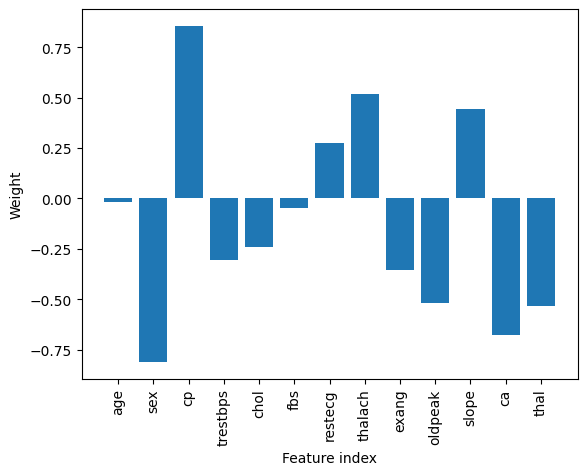

In [40]:
# grab the coefficient vector (parameters)
weights = clf.coef_[0]
print(weights)

print(heartData.columns.values)
col_names = heartData.columns.values[:13, ] # subsetting out the target variable as no weight exists for it 

#generating bar plot 
plt.bar(range(len(weights)), weights)
plt.xlabel('Feature index')
plt.ylabel('Weight')
plt.xticks(range(len(weights)), col_names, rotation=90) #labeling x-axis with corresponding features
plt.show()

## Discussion 

The features which correlate to high absolute values in their weights such as sex, and cp, are likely showing larger weights because they have a strong correlation with the target variable. In other words, they offer more insight about the target variable and thus have their signals amplified within the model. This means they are being weighted more heavily, and are thus more powerful in producing good predictions according to the model. 